#Preprocessing

In [4]:
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
from string import punctuation
import matplotlib.pyplot as plt
from collections import Counter, OrderedDict
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import seaborn as sns

sns.set(palette="Set2")
sns.set_style("whitegrid")


device = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda" if torch.cuda.is_available() else "cpu"
)

In [5]:
import zipfile
import os

from google.colab import drive

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!mkdir data

In [5]:
!unzip 'drive/MyDrive/DS/Image_Text_similarity/test.zip' -d "data/train"

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: data/train/test/competition_data:60877.png  
  inflating: data/train/test/competition_data:83075.png  
  inflating: data/train/test/competition_data:38764.png  
  inflating: data/train/test/competition_data:68629.png  
  inflating: data/train/test/competition_data:20885.png  
  inflating: data/train/test/competition_data:304164.png  
  inflating: data/train/test/competition_data:257333.png  
  inflating: data/train/test/competition_data:240606.png  
  inflating: data/train/test/competition_data:69545.png  
  inflating: data/train/test/competition_data:138360.png  
  inflating: data/train/test/competition_data:298345.png  
  inflating: data/train/test/competition_data:163756.png  
  inflating: data/train/test/competition_data:253106.png  
  inflating: data/train/test/competition_data:56336.png  
  inflating: data/train/test/competition_data:160653.png  
  inflating: data/train/test/competition_data:122843.p

In [6]:
test_dataset = pd.read_table("drive/MyDrive/DS/Image_Text_similarity/test_no_target.tsv")
test_dataset.head()

,filename,text
0,test/competition_data:117096.png,кабаева и ее дети фото
1,test/competition_data:196699.png,асадов лучшие стихи
2,test/competition_data:242127.png,журнал приказов по личному составу
3,test/competition_data:292007.png,talpa de la picior
4,test/competition_data:51895.png,диафильм фото


#inference

In [7]:
!pip install --upgrade -q git+https://github.com/huggingface/transformers sentencepiece

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 10.5 MB/s eta 0:00:00


In [8]:
!pip install datasets faiss-gpu git+https://github.com/NielsRogge/transformers.git@add_siglip sentencepiece

  Cloning https://github.com/NielsRogge/transformers.git (to revision add_siglip) to /tmp/pip-req-build-43rzqxpl
  Running command git clone --filter=blob:none --quiet https://github.com/NielsRogge/transformers.git /tmp/pip-req-build-43rzqxpl
  Running command git checkout -b add_siglip --track origin/add_siglip
  Switched to a new branch 'add_siglip'
  Branch 'add_siglip' set up to track remote branch 'add_siglip' from 'origin'.
  Resolved https://github.com/NielsRogge/transformers.git to commit 5e3df73614f60a9039ffc7c2f5e2b4264f34e6d9
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 22.6 MB/s eta 0:

In [2]:
from transformers import AutoProcessor, SiglipModel, AutoImageProcessor, AutoModel, AutoTokenizer

processor = AutoProcessor.from_pretrained("nielsr/siglip-base-patch16-224")
tokenizer = AutoTokenizer.from_pretrained("nielsr/siglip-base-patch16-224")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [7]:
model = SiglipModel.from_pretrained("nielsr/siglip-base-patch16-224").to(device)

In [8]:
import faiss
from PIL import Image
from sklearn.preprocessing import normalize

def add_vector(embedding, index):
    vector = embedding.detach().cpu().numpy()
    vector = np.float32(vector)
    # faiss.normalize_L2(vector)
    # index.add(vector)
    vector = vector / np.linalg.norm(vector)
    index = np.append(index, vector, axis=0)
    # print(vector.shape)
    return index


def embed_image_siglip(image):
    with torch.no_grad():
        inputs = processor(images=image, return_tensors="pt").to(device)
        image_features = model.get_image_features(**inputs)
    return image_features


def emb_text_siglib(text):
    with torch.no_grad():
        text_token = tokenizer([text], return_tensors="pt").to(device)
        text_features = model.get_text_features(**text_token)
    return text_features

In [20]:
%time
p = "data/train/"
index_img = np.zeros(shape=(1, 768))
index_text = np.zeros(shape=(1, 768))

for idx in range(len(test_dataset)):
    text = test_dataset['text'][idx]
    part = p + test_dataset['filename'][idx]
    assert len(index_text) == len(index_img), "Worng shapes"

    try:
        image = Image.open(part)
        clip_features = embed_image_siglip(image)
        index_img = add_vector(clip_features, index_img)
    except:
        index_img = np.append(index_img, np.zeros(shape=(1, 768)), axis=0)

    try:
        clip_features = emb_text_siglib(text)
        index_text = add_vector(clip_features, index_text)
    except:
        index_text = np.append(index_text, np.zeros(shape=(1, 768)), axis=0)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.63 µs


In [21]:
new_ds = test_dataset.iloc[:len(test_dataset)]

In [22]:
index_img.shape

(12001, 768)

In [23]:
index_text.shape

(12001, 768)

In [24]:
len(test_dataset)

12000

In [26]:
new_ds.insert(2, "Text_vect", index_text.tolist()[1:], True)
new_ds.insert(3, "Image_vect", index_img.tolist()[1:], True)

new_ds.head()

,filename,text,Text_vect,Image_vect
0,test/competition_data:117096.png,кабаева и ее дети фото,"[0.0017313087591901422, 0.010637959465384483, ...","[0.015086292289197445, -0.016344934701919556, ..."
1,test/competition_data:196699.png,асадов лучшие стихи,"[0.02080153301358223, 0.03131737932562828, -0....","[-0.03994952514767647, -0.016224808990955353, ..."
2,test/competition_data:242127.png,журнал приказов по личному составу,"[-0.013448970392346382, 0.02264389954507351, -...","[0.0035359645262360573, 0.0030201554764062166,..."
3,test/competition_data:292007.png,talpa de la picior,"[-0.029750630259513855, 0.007984066382050514, ...","[-0.016168545931577682, -0.0003600974741857499..."
4,test/competition_data:51895.png,диафильм фото,"[0.01704467087984085, 0.017613278701901436, -0...","[0.022487318143248558, -0.007645448204129934, ..."


In [27]:
new_ds.to_csv('df_embds.csv', index=False)

In [28]:
!zip -r 'zip_embs.zip' 'df_embds.csv'

  adding: df_embds.csv (deflated 58%)


In [29]:
from numpy import dot
from numpy.linalg import norm

def cos_sim(a, b):
    if norm(a) == 0.0 || norm(b) == 0.0:
        return 0.0
    return dot(a, b)/(norm(a)*norm(b))

In [38]:
ds_copied = test_dataset.iloc[:len(test_dataset)]
ds_copied.head()

,filename,text
0,test/competition_data:117096.png,кабаева и ее дети фото
1,test/competition_data:196699.png,асадов лучшие стихи
2,test/competition_data:242127.png,журнал приказов по личному составу
3,test/competition_data:292007.png,talpa de la picior
4,test/competition_data:51895.png,диафильм фото


In [39]:
assert index_img.shape == index_text.shape, 'dwonoewf'

cosine_sim = [abs(cos_sim(index_img[idx], index_text[idx])) for idx in range(len(index_img))]
len(cosine_sim)

<ipython-input-29-921b4c83b639>:5: RuntimeWarning: invalid value encountered in scalar divide
  return dot(a, b)/(norm(a)*norm(b))


12001

In [40]:
ds_copied.insert(2, "Cos_sim", cosine_sim[1:], True)

ds_copied.head()

,filename,text,Cos_sim
0,test/competition_data:117096.png,кабаева и ее дети фото,0.032988
1,test/competition_data:196699.png,асадов лучшие стихи,0.019003
2,test/competition_data:242127.png,журнал приказов по личному составу,0.033059
3,test/competition_data:292007.png,talpa de la picior,0.077223
4,test/competition_data:51895.png,диафильм фото,0.043578


In [41]:
ds_copied.to_csv('df_cos.csv', index=False)

In [43]:
train_cos = pd.read_csv("train_cos.csv")
train_cos.head()

,filename,text,mark,cos_sim
0,train/competition_data:161523.png,анемона многолетняя,Удовлетворительно,0.000000
1,train/competition_data:72060.png,аргасовые клещи виды,Идеально,0.042112
2,train/competition_data:318752.png,правила безопасного поведения во время таянья ...,Идеально,0.026944
3,train/competition_data:4563.png,ресторан каса агава,Идеально,0.032681
4,train/competition_data:167632.png,стихи о детях войны,Удовлетворительно,0.023862


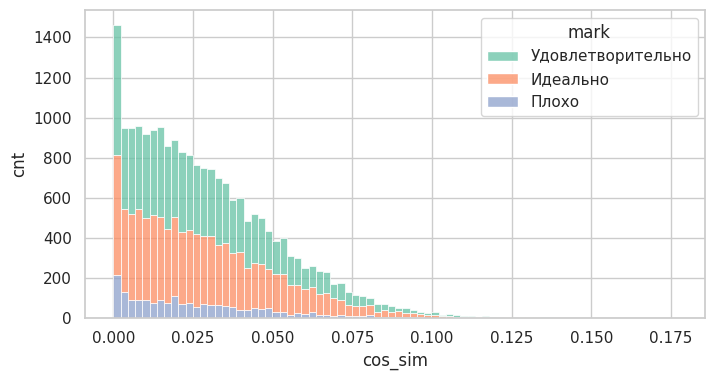

In [47]:
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(8, 4))
    hist = sns.histplot(data=train_cos, x='cos_sim', hue='mark', multiple="stack")

    leg = hist.get_legend()

    plt.xlabel('cos_sim')
    plt.ylabel('cnt')

#Classifying

In [48]:
!pip install xgboost

In [49]:
!unzip "zip_train_embs.zip"

Archive:  zip_train_embs.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of zip_train_embs.zip or
        zip_train_embs.zip.zip, and cannot find zip_train_embs.zip.ZIP, period.


In [ ]:
import xgboost as xgb


dtrain = xgb.DMatrix(X_train, label=y_train, weight=weights_train)
#dtest = xgb.DMatrix(X_test, label=y_test)

param = {
    'reg_alpha': 0.5,
    'reg_lambda': 1,
    'n_estimators': 100,
    'learning_rate': 0.5,
    'max_leaves': 5,
   'max_depth': 10,
   'device': 'cuda',
   'eta': 0.25,
   'silent': 1,
   'objective': 'multi:softprob',
   'num_class': 2}
num_round = 50

bst = xgb.train(param, dtrain, num_round)

In [ ]:
dtest1 = xgb.DMatrix(X_test1, label=y_test1)
y_pred_xgboost = bst.predict(dtest1)